In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from LoadData import loaddata, filter_zeroes

simulation_names = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'g14', 'Marvel_JL']
data = loaddata(simulation_names)

inputHistories = np.array([element[0] for element in data])
mass_presentsfr = np.array([element[1] for element in data])
labels = np.array([element[2] for element in data])

for i in range(len(labels)):
    if labels[i] == 'Eagle':
        labels[i] = 0
    elif labels[i] == 'Illustris':
        labels[i] = 1
    elif labels[i] == 'IllustrisTNG':
        labels[i] = 2
    elif labels[i] == 'Mufasa':
        labels[i] = 3
    elif labels[i] == 'Simba':
        labels[i] = 4
    elif labels[i] == 'SC-Sam':
        labels[i] = 5
    elif labels[i] == 'UniverseMachine':
        labels[i] = 6
    elif labels[i] == 'Fire-2':
        labels[i] = 7
    elif labels[i] == 'g14':
        labels[i] = 8
    elif labels[i] == 'Marvel_JL':
        labels[i] = 9
labels = np.array(labels).astype('float32')


filtered_inputHistories, filtered_mass_presentsfr, filtered_labels = filter_zeroes(inputHistories, mass_presentsfr, labels)
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(filtered_inputHistories, filtered_mass_presentsfr, test_size=0.2, random_state=42)

# Normalize the star formation histories
X_train = [(sfh / (np.trapz(sfh)) * 500) for sfh in X_train]  # Normalize SFH
X_test = [(sfh / (np.trapz(sfh)) * 500) for sfh in X_test]    # Normalize SFH

X_train = np.array(X_train)
X_test = np.array(X_test)

# Further split the training data into 80% (64%) training and 20% (16%) validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

device = "mps"
print(f"Using {device} device")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32) 
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

Using mps device


In [4]:
import torch.optim as optim

# Define the neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=4, padding=1)  
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=4, padding=1)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=1)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=1)  
        self.pool = nn.MaxPool1d(2, 2)  
        self.fc1 = nn.Linear(16 * 7, 64)  
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))  
        x = x.view(-1, 16 * 7)  # Matching new dimensions after convolutions and pooling
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create the model instance
regr = CNN().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Assuming regression task with MSE loss
optimizer = optim.Adam(regr.parameters(), lr=0.001)

# Create a DataLoader for batch processing
dataset = TensorDataset(X_train_tensor.unsqueeze(1), y_train_tensor)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True)

val_dataset = TensorDataset(X_val_tensor.unsqueeze(1), y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=200, shuffle=False)

CNN(
  (conv1): Conv1d(1, 16, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv3): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv4): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=112, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
Epoch [10/300], Training Loss: 0.1440, Val Loss: 0.1390
Epoch [20/300], Training Loss: 0.1040, Val Loss: 0.1015
Epoch [30/300], Training Loss: 0.0866, Val Loss: 0.0868
Epoch [40/300], Training Loss: 0.0685, Val Loss: 0.0844
Epoch [50/300], Training Loss: 0.0580, Val Loss: 0.0701
Epoch [60/300], Training Loss: 0.0536, Val Loss: 0.0660
Epoch [70/300], Training Loss: 0.0484, Val Loss: 0.0582
Epoch [80/300], Training Loss: 0.0467, Val Loss: 0.06

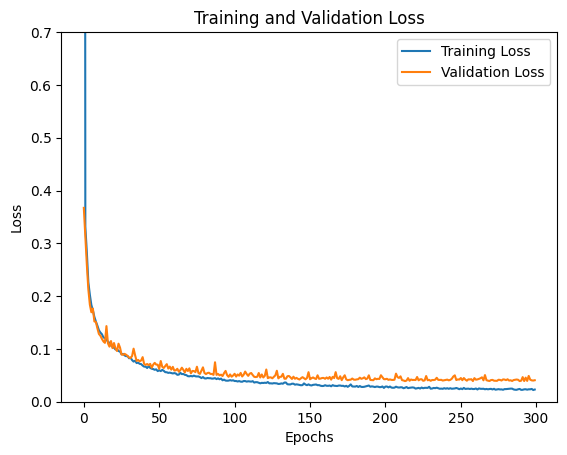

In [5]:
print(regr)
# Training loop
num_epochs = 300
losses = [] # To store training losses
val_losses = []  # To store validation losses

for epoch in range(num_epochs):
    loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = regr(inputs)
        curr_loss = criterion(outputs, targets)
        curr_loss.backward()
        optimizer.step()
        loss += curr_loss.item()

    loss /= len(dataloader)
    losses.append(loss)
    
    regr.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_dataloader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = regr(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()
    
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:  
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

print('Training complete')
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,0.7)
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [23]:
with torch.no_grad():
    y_pred_tensor = regr(X_test_tensor.unsqueeze(1).to(device))

y_pred = y_pred_tensor.cpu()

In [24]:
pred_mass = y_pred.T[0]
pred_sfr = y_pred.T[1]

In [25]:
stellar_mass = y_test_tensor.T[0]
star_formation_rate = y_test_tensor.T[1]

Score for log stellar mass: 0.8995606899261475
Score for arcsinh SFR: 0.8898233771324158

RMSE for Stellar Mass: 0.20081593096256256 
RMSE for SFR: 0.2205919325351715

Baseline RMSE for Stellar Mass: 0.6336454153060913 (Predicting the mean) 
Baseline RMSE for SFR: 0.6645764112472534 (Predicting the mean)

1,5,10,50,90,95,99 Percentiles for mass residuals: [-0.51647539 -0.2484509  -0.17040777  0.01298809  0.22296591  0.3319499
  0.59463363]

1,5,10,50,90,95,99 Percentiles for SFR residuals: [-0.57274296 -0.2220802  -0.11262521  0.04517513  0.22801235  0.34293158
  0.69567559]


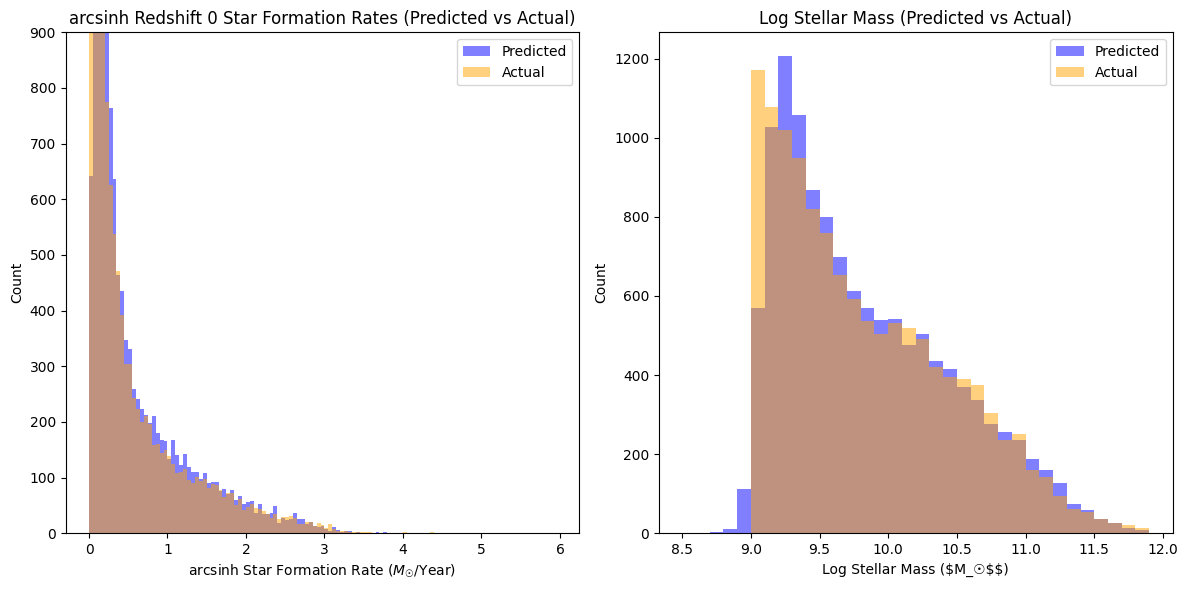

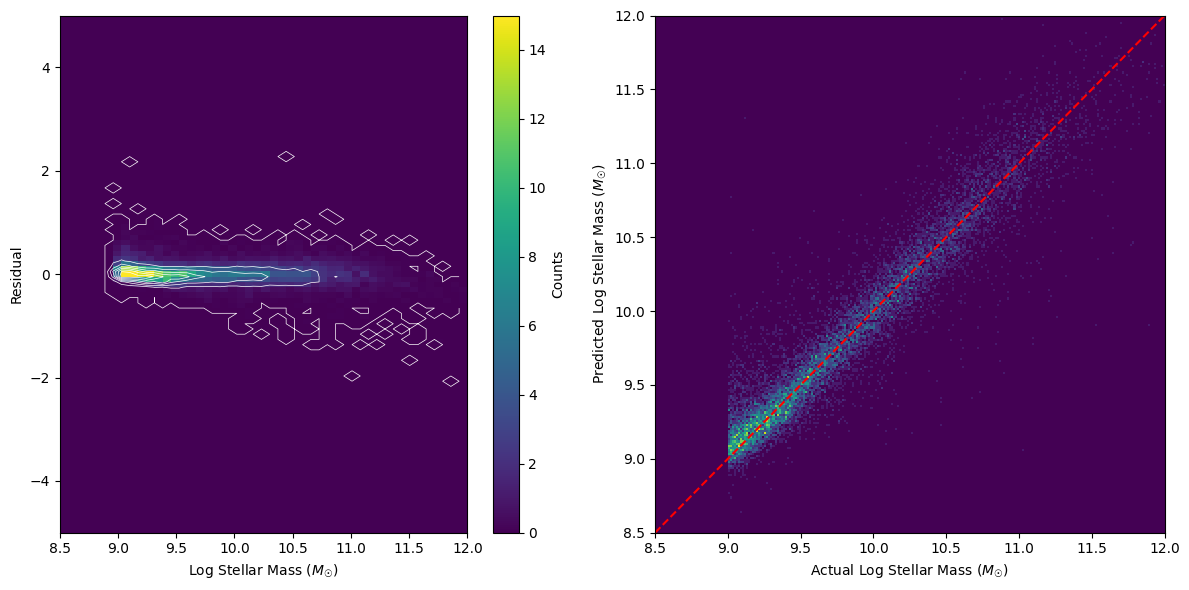

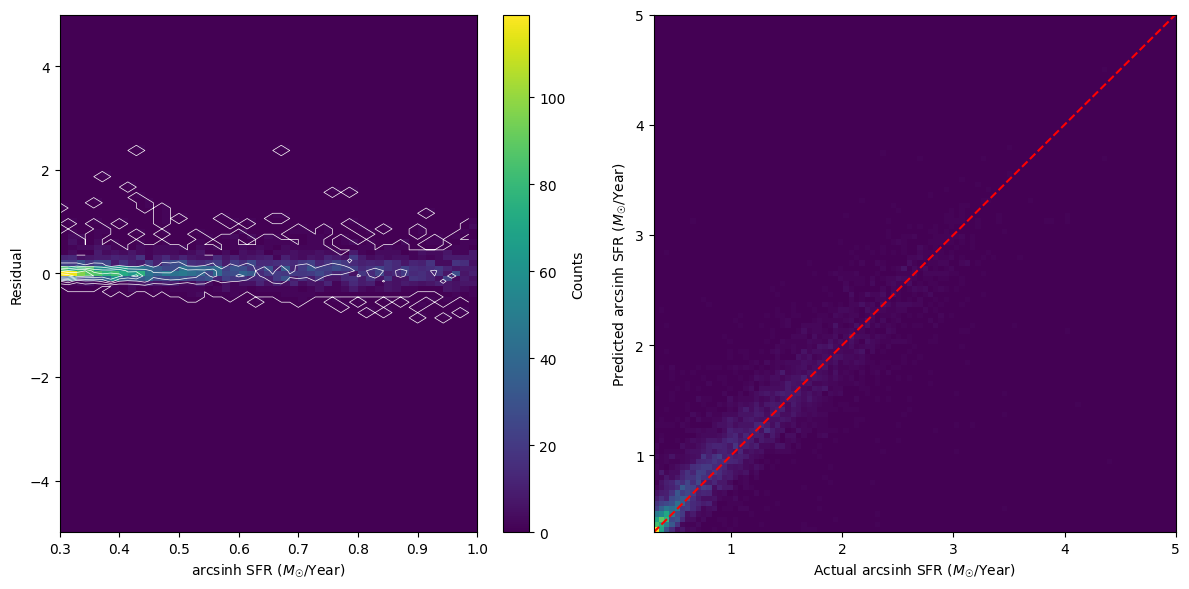

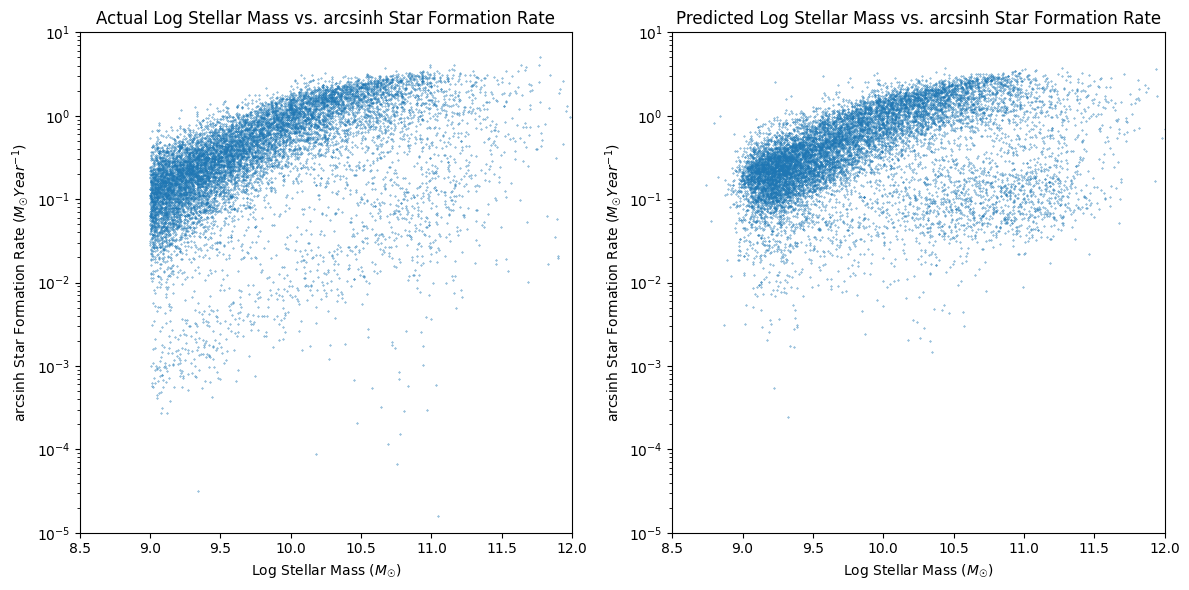

In [26]:
from DataEval import pred_actual_data_eval, pred_actual_data_vis
pred_actual_data_eval(pred_mass, pred_sfr, stellar_mass, star_formation_rate)
pred_actual_data_vis(pred_mass, pred_sfr, stellar_mass, star_formation_rate)